In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
base_dir = 'dataset' # Assuming the dataset structure is as follows:
train_dir = os.path.join(base_dir, 'train') # Directory for training images
validation_dir = os.path.join(base_dir, 'validation') # Directory for validation images
test_dir = os.path.join(base_dir, 'test') # Directory for test images

In [ ]:
train_datagen = ImageDataGenerator( # Data augmentation parameters
    rescale=1./255, # Rescale pixel values to [0, 1]
    rotation_range=30, # Randomly rotate images by up to 30 degrees
    width_shift_range=0.3,  # Randomly shift images horizontally by up to 30% of the width
    height_shift_range=0.3, # Randomly shift images vertically by up to 30% of the height
    shear_range=0.2, # Shear angle in counter-clockwise direction in degrees
    zoom_range=0.2, # Randomly zoom in on images by up to 20%
    horizontal_flip=True, # Randomly flip images horizontally
    ) 

val_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
img_size = (128, 128) # Target size for images
batch_size = 32 # Batch size for training and validation

# Create generators for training, validation, and test datasets
train_generator = train_datagen.flow_from_directory( 
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size, 
    class_mode='binary',
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,  
    class_mode='binary',
    shuffle=False,
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12461 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices) # Print class indices to understand the mapping of classes to labels

{'cats': 0, 'dogs': 1}


In [ ]:
# Define the CNN model 
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=img_size + (3,)), # Input shape is (height, width, channels)
    MaxPooling2D((2, 2)), # Downsample the feature maps by taking the maximum value in each 2x2 block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(), # Flatten the 3D output to 1D
    Dense(64, activation='relu'), # Fully connected layer with 64 units
    Dropout(0.5), # Dropout layer to prevent overfitting
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Output layer with 1 unit for binary classification
])

c:\Users\Henrique\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
learning_rate = 0.001 # Learning rate for the optimizer
optimizer = Adam(learning_rate=learning_rate) 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Early stopping to prevent overfitting 

In [ ]:
history = model.fit( # Train the model
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping],
)

c:\Users\Henrique\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 232ms/step - accuracy: 0.4997 - loss: 0.6957 - val_accuracy: 0.5248 - val_loss: 0.6864
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 173ms/step - accuracy: 0.5437 - loss: 0.6873 - val_accuracy: 0.5432 - val_loss: 0.6742
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 151ms/step - accuracy: 0.5814 - loss: 0.6752 - val_accuracy: 0.6100 - val_loss: 0.6465
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 152ms/step - accuracy: 0.6270 - loss: 0.6465 - val_accuracy: 0.6334 - val_loss: 0.6349
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 152ms/step - accuracy: 0.6493 - loss: 0.6287 - val_accuracy: 0.6372 - val_loss: 0.6237
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 154ms/step - accuracy: 0.6628 - loss: 0.6102 - val_accuracy: 0.6968 - val_loss: 0.5789
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 97s 156ms/step - accuracy: 0.6969 - loss: 0.5846 - val_accuracy: 0.7108 - val_loss: 0.5587
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step - accuracy: 0.7040 - loss:

In [9]:
y_true = test_generator.classes  # Rótulos reais
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Binariza as probabilidades

390/390 ━━━━━━━━━━━━━━━━━━━━ 99s 253ms/step


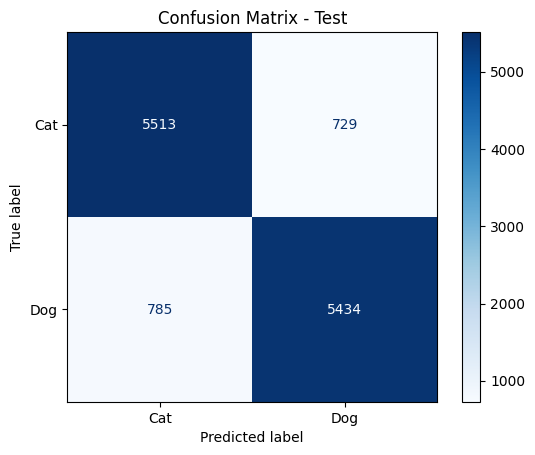

In [14]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test")
plt.show()

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,122,181 (19.54 MB)

 Trainable params: 1,707,393 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,414,788 (13.03 MB)

In [11]:
print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

              precision    recall  f1-score   support

         Cat       0.88      0.88      0.88      6242
         Dog       0.88      0.87      0.88      6219

    accuracy                           0.88     12461
   macro avg       0.88      0.88      0.88     12461
weighted avg       0.88      0.88      0.88     12461



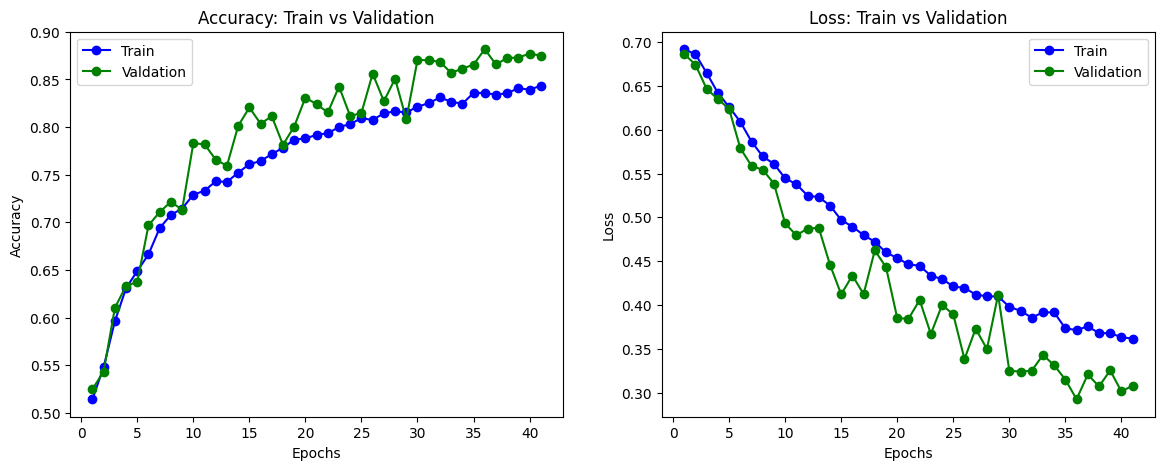

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Train')
plt.plot(epochs, val_acc, 'go-', label='Valdation')
plt.title('Accuracy: Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Train')
plt.plot(epochs, val_loss, 'go-', label='Validation')
plt.title('Loss: Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()